# Anomaly Detection Tutorial
This notebook details concepts surrounding anomaly detection in battery data. Specifically, we will be investigating anomalies in the cycling behavior of a batch of nominally identical cells that were tested under a variety of fast-charge cycling protocols. The cells used within this demonstration are a set of 134 LFP 18650 cells from a dataset generated by [Severson et al.](https://web.mit.edu/braatzgroup/Severson_NatureEnergy_2019.pdf)

The segments are as follows:
1. [Data preparation and feature engineering](#Data-preparation-and-feature-engineering)
1. [Statistical approaches](#Statistical-approaches)
1. [Machine learning (ML) approaches](#Machine-learning-(ML)-approaches)

In [1]:
pip install pyod

  Using cached pyod-1.0.6-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [2]:
import voltaiq_studio as vs
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

# ML packages are imported in their respective sections for easier reference

## Data preparation and feature engineering
Data preparation and feature engineering are the most crucial steps in the process of anomaly detection. Anomaly detection algorithms can only be as good as the data that is input into the model. Features that have been generated with domain knowledge can improve ML algorithm performnce and result in more relevant anomalies being detected.

In this section, we will learn how to:
1. Load the dataset into Voltaiq Analytics Studio
1. [Generate features of interest for anomaly detection](#Data-Feature-Engineering)
1. [Explore the dataset characteristics](#Data-Exploration)
1. [Standardize/scale features](#Data-Standardization-and-Scaling)

In [3]:
# we begin by loading in test records
trs = vs.get_test_records()

In [4]:
def find_tr_by_uuids(uuid_list):
    ''' return a dictionary of test record by uuid values for each uuid in uuid_list'''
    cart_group = {}
    for uuid in uuid_list:
        try:
            cart_group[uuid] = vs.get_test_record(uuid)
        except:
            pass
    return cart_group

The Severson dataset is made up of three batches of cells that were tested starting at different timepoints. We will load the three batches into a single dataframe, but keep track of the batch number in case it becomes relevant in our anomaly detection

In [5]:
# next, we will select the test records of interest, specifically those from the Severson publication
severson_05_12 = ['76685d77-f992-42a3-ad91-25acfe68949c', '5eda8ce9-939c-4d3b-b01c-6ea8af5191a8', 'bfb2aeb6-661a-4fde-96aa-a1c72ce16c16', '81b7fecf-dca5-4c72-b681-af334e2dc165', 'd61be646-f5d3-4006-aa84-8f6c186c4f84', 'e582917f-5610-4132-8207-97fb9b4dec12', 'c4aec7d8-28d8-4586-9764-d850ce1c4c9b', 'd0a79d83-a6f6-4f81-b901-0507b17010f7', 'e0e6d51b-9053-4585-87b6-e504f0a80429', '5476c7b3-e3d2-4f3e-92a9-6dfe75a60430', '081d8edd-e766-4ee8-b34e-0ffdfce19a9b', '0e9d564f-671e-4b03-8a00-086977df8f64', '1dc445e6-b601-4307-9be1-b8c9d7022927', '206c5fa4-d57a-4501-8c5a-18ad2eafc030', 'b2bc86db-ae8f-42c9-8d53-ab94db98e2c1', 'e47fe9fc-ea4c-4b3b-a756-7be1f366b1a1', 'cde5f9bd-a971-4681-b629-0e4bc900d9aa', '477f23fd-edba-4e68-956d-853e7a753d22', 'f50461aa-ac26-4472-8bd7-db67b1434676', 'f52a16d6-7b50-437b-865c-4cd66e29a481', 'ff2579bd-adb3-417e-bd98-1212520d2176', 'a7b2ae6d-6ecc-4e3c-ba96-b7d0596fa04a', '38905d9e-7c53-4b6a-ad64-3e9123ae0ce3', '474b90d6-1b94-4405-a10e-1fa33463f61f', '303782b7-fa77-43f0-a57f-562ee1285719', 'b6be21df-b1f8-4bc2-bda3-ffdcef3c9f20', '90eab06f-4ac2-48ee-b197-140d4330456a', '966ed27c-6cb8-4ef0-82cc-a2de5c56691a', 'e02e6d97-1e49-44d4-bfe3-4725ba7b3ecc', 'c52c5cc7-72e8-4012-ac3a-49ea8bff8323', '601782bf-4940-46e1-bd7d-cb6558b59308', '2d61a1bf-26dd-427c-99d6-f6c671728d98', '42ee9ad1-81f7-4f43-8988-9770a3810923', 'b33d25ac-9a22-4aae-89d4-b7822ae0746c', 'e2f97f77-16fc-445a-ac8c-cad60f916c49', '7df56373-c2ee-401a-83ab-a73000f1fa80', 'a6fb9b48-510d-4d8f-8e62-1ffa5a453341', '96c3bfc5-def8-464b-a660-bc595af45f48', 'a2ed32f7-e769-417b-b96c-aa9c16142e95', 'c59e3071-f7fd-4419-a0eb-c165f13fca40', 'b2fa91b0-b3e2-4549-ae73-37252eea7be3', '663c19a5-7872-4ec1-bb58-9f1bc6e894b1', '81d60b1e-a012-431d-a1a2-fcc30e97ce71', '8e83afa1-2230-45af-96d1-6137eda9bea6', '6a2d154b-d9fb-43ed-ab0f-9d63481db691']
severson_06_30 = ['4362f74d-8ddd-4fc0-a489-a56a2611a847', 'cd8d9250-54b4-40ad-a89f-10d3a08509a7', '9679395b-babb-4e3a-aaab-eb72ca532f00', 'dfee5a9f-f3e7-473d-ba67-522d2b5b1411', '2d49ec41-216d-4c1e-be7f-1dd5d5b413e3', 'a1d6eb5e-9799-4d5e-9897-6500c88ca6a0', 'd164c146-a389-4894-8bfa-657d9b04a501', '9b2e8522-90b5-4336-b53a-67ff0324e9fa', '84c9c239-a9ab-495c-bd86-5b3eb2f8ec32', '4e51eea7-e40a-46a8-8e40-ab26ee4a15f9', '7bb1d8cd-8f35-4886-ae30-81f7cfd159e6', 'f4d66d50-1de1-439a-8cf3-3d64ad9bd553', '00f76685-a047-49c5-8145-429e24087cec', '9cdc5ded-ae8d-416a-b40f-5e81f224bdab', 'bbf7e593-260e-4391-a62a-dbe5ad5f515f', '6a118b63-cb79-45b1-b870-7022fe1d679b', 'f862fa82-3bf3-4ab6-9ed7-d19265dc1ee3', 'bb54188b-f5d7-46ff-b86d-e019f12a0863', 'd167cb97-c558-4cb9-a28d-051be4534e8c', 'ad838747-2830-45ca-ab4b-74afbdf0912d', '8d832841-1bb8-4171-9144-b623c12d1260', '9d810995-6121-48a4-a0ee-3643e6b316fa', '37658b02-afde-4b85-8a6c-22502e2a2419', 'edf28fae-c15b-4f53-bb62-98d4a4ea6ac9', '70a18b11-24c8-4740-b218-706a8add2efc', '3d3d2f69-473d-472b-92f2-0f4157d055d6', '4bde8e68-f0df-4e23-8373-6f053e57b806', 'd49b79fa-52ee-4c76-8dba-bfd68760f16f', 'e9b88d79-7750-40df-af2b-640ca46268ca', '43761484-6709-4c26-ab49-b57b7b52bfd1', '4491596f-07bf-416e-beae-e4d94a010973', '20bc65b6-00cc-4dc1-b2ba-bba55a1eb6c4', '21cfacd0-d8b3-4814-b690-251ba30b5de4', '4155f28c-e8f6-4c3f-a982-a4f4ffc81c28', '6cee6025-68e1-4802-8acb-35be670c0df5', '28cb51af-3353-4ab6-83ae-60d00a9779da', '9ce5671b-e2b3-4e68-80c5-1607e68be4e6', '9b22ee50-9fa1-4527-9e92-74f9cb54d2ca', 'aea1c143-40b9-4d3b-8655-5c7e839d13c6', '957374f4-c96c-4ae0-be40-bb07f0dac000', 'b35d91e9-6653-4f63-9931-646398d62496', 'b9ebbe13-6825-4bf8-9ff8-255ecd9e9949', '371515cb-d61d-4060-be7f-449ab78e502e']
severson_04_12 = ['cc0b9860-dacd-403b-b6c8-9175406df418', '195d1c8e-cfef-4d5d-a3f6-5e2cc48be31f', '4c156952-4e76-4881-bdf1-ba99fc7ee236', '6c6d9aa7-1ea3-4987-a504-7389af859a2b', 'baee6fdf-c7b1-4fe0-b345-7af0ff88cd12', 'e34cd289-a2a7-4ab1-bdd2-ee18e38bfd21', '47935484-a313-4780-a9f1-db9ee151987a', '9302017f-c5f8-40eb-beee-18855dce9f24', 'd5126a65-9738-4753-b72e-f29b9fa80ea1', 'af29c78b-bfde-4514-86f7-04508590bd82', 'ae0c2c05-3e98-4b12-9fa5-59dfbe0608df', 'e3c1f9ee-df96-4d77-8c9d-12c9ce7a71e0', '62492c1d-c798-429e-a37e-ac0dc181bba1', 'db19ab41-3a7a-47bd-9f63-fb5d4b11ecd0', 'bf99a2db-b334-49f8-a609-65d507822a6b', 'b0fc3c22-8d5c-42cd-b02c-83eedd673775', 'e05d86c2-1e93-424e-ac18-fe14e1e55090', '099a3892-3bf2-4549-9d4c-49b19c91256a', '542384df-c019-4be5-913a-e386fee66549', '2b9ac9ab-ed4b-4208-94f3-0d34847d9dd1', 'ff20f251-2430-443b-98a4-c8433bd0a795', 'eb0ff6af-09f6-43fd-8734-4ad5f9636533', '49ef6241-19b7-4171-93bf-d76b5a6bf095', '3adc5f45-43ee-490e-ada3-0127517bf4ec', '1e2b1a52-3849-40a4-ad58-ae8230750521', '291a2242-647b-4e97-9ae9-696926facc0e', '0c3215e2-2693-443d-9a0c-ddc29490360f', '13353930-5b72-4374-939f-9ecf0737dbd8', '2318ac5f-5481-44c0-b5c6-caaed44daac0', '38b5aaa8-0325-4cc8-83dd-d7e258bf805f', 'c4c34dd7-9e3f-4ad0-a993-0b3d13eb09a7', '4add3f4d-cdda-48d2-8134-00ea8003204f', '63d2c098-13bd-4898-9018-657ee3c3b776', '54475e4c-c945-4429-99c5-6b05f7ee8652', '39168f10-79ac-4984-aa9d-b21278ecc2ec', '9579cc2b-75a5-484c-ab0b-68e1fc318277', '92bf8a07-7b10-48b0-b786-108af7a9d9fc', 'b1c5ab3b-520e-4a5a-9e54-1de78fe578c3', '0c223b39-8770-44bd-b82b-8838b53b1d3d', 'ebea57f1-d349-4f88-9ed9-7e031d423225', '39007d17-7daf-4b7f-8d2c-4fe7891ca758', '9d23000e-00f8-4727-b3ea-cf51d6465147', '9d1e81fc-58dd-49f0-aecb-36b71b14da48', '45fc1a72-e79e-4a82-a24f-39e580cc6149', '3959e586-808e-4383-b0b5-0be18fbedac3', '89aaf07c-512f-4cff-8b12-f56f4388e2a2']
severson_05_12_tr = find_tr_by_uuids(severson_05_12)
severson_06_30_tr = find_tr_by_uuids(severson_06_30)
severson_04_12_tr = find_tr_by_uuids(severson_04_12)
severson_05_12_df = pd.DataFrame({"Test Name":[test.name for uuid,test in severson_05_12_tr.items()],"UUID":[uuid for uuid,test in severson_05_12_tr.items()],
                              "Total cycles":[test.total_cycles for uuid,test in severson_05_12_tr.items()], "Test_object": [test for uuid,test in severson_05_12_tr.items()],
                                 "Batch":[1]*len(severson_05_12_tr)})
severson_06_30_df = pd.DataFrame({"Test Name":[test.name for uuid,test in severson_06_30_tr.items()],"UUID":[uuid for uuid,test in severson_06_30_tr.items()],
                              "Total cycles":[test.total_cycles for uuid,test in severson_06_30_tr.items()], "Test_object": [test for uuid,test in severson_06_30_tr.items()],
                                 "Batch":[2]*len(severson_06_30_tr)})
severson_04_12_df = pd.DataFrame({"Test Name":[test.name for uuid,test in severson_04_12_tr.items()],"UUID":[uuid for uuid,test in severson_04_12_tr.items()],
                              "Total cycles":[test.total_cycles for uuid,test in severson_04_12_tr.items()], "Test_object": [test for uuid,test in severson_04_12_tr.items()],
                                 "Batch":[3]*len(severson_04_12_tr)})
all_tests_df = pd.concat([severson_05_12_df, severson_06_30_df, severson_04_12_df],axis=0,ignore_index=True)
print("Number of test records: ",len(all_tests_df))

Number of test records:  134


In [6]:
# We can take a look at what we've loaded:
all_tests_df.head()

,Test Name,UUID,Total cycles,Test_object,Batch
0,2017-05-12_5_4C-70per_3C_CH17_VDF,76685d77-f992-42a3-ad91-25acfe68949c,692,"TestRecord(id=10887, uuid='76685d77-f992-42a3-...",1
1,2017-05-12_5_4C-80per_5_4C_CH12_VDF,5eda8ce9-939c-4d3b-b01c-6ea8af5191a8,560,"TestRecord(id=10111, uuid='5eda8ce9-939c-4d3b-...",1
2,2017-05-12_5_4C-80per_5_4C_CH11_VDF,bfb2aeb6-661a-4fde-96aa-a1c72ce16c16,535,"TestRecord(id=10110, uuid='bfb2aeb6-661a-4fde-...",1
3,2017-05-12_4_8C-80per_4_8C_CH9_VDF,81b7fecf-dca5-4c72-b681-af334e2dc165,871,"TestRecord(id=10109, uuid='81b7fecf-dca5-4c72-...",1
4,2017-05-12_4_8C-80per_4_8C_CH10_VDF,d61be646-f5d3-4006-aa84-8f6c186c4f84,637,"TestRecord(id=10108, uuid='d61be646-f5d3-4006-...",1


### Data Feature Engineering
Now that we have the dataset we would like to work with, we will generate the features that we would like to monitor to help us detect anomalies. Here are some example features that may be relevant:
- Charge/discharge capacity/energy, coulombic efficiency for select cycles (we will choose cycles 1, 10, 100 and 500 in this tutorial)
- Min/max potentials for specific cycles as well as the mean over all cycles
- Trends in a single feature over specific cycles - such as the difference between the discharge capacity between cycle 10 and cycle 100

This feature engineering step is the hardest and most interesting step. Think critically about your dataset, what you are trying to monitor, and what parameters are important to your application! Think out of the box regarding ratios, descriptive statistics and trends! We have only provided some descriptive examples above, but this is by no means an exhaustive (or necessary) list.

To identify some possible feature inputs that you might want to start with, you can examine the list of per-cycle statistics that Voltaiq automatically calculates for every test record using the command:
`all_tests_df.Test_object[0].get_cycle_stats().columns`

In [7]:
all_tests_df.Test_object[0].get_cycle_stats().columns

Index(['cycle_number', 'cycle_ord', 'cyc_charge_capacity', 'cyc_charge_energy',
       'cyc_charge_relaxation_dpt', 'cyc_charge_relaxation_potential',
       'cyc_coulombic_efficiency', 'cyc_cv_charge_time',
       'cyc_cv_discharge_time', 'cyc_cycle', 'cyc_discharge_capacity',
       'cyc_discharge_energy', 'cyc_discharge_relaxation_dpt',
       'cyc_discharge_relaxation_potential', 'cyc_energy_efficiency',
       'cyc_ir_charge', 'cyc_ir_discharge', 'cyc_max_charge_power',
       'cyc_max_cumulative_capacity', 'cyc_max_cumulative_energy',
       'cyc_max_differential_capacity', 'cyc_max_differential_energy',
       'cyc_max_discharge_power', 'cyc_max_ocp', 'cyc_max_ocp_dpt',
       'cyc_max_potential', 'cyc_max_potential_dpt',
       'cyc_mean_charge_potential', 'cyc_mean_charge_power',
       'cyc_mean_discharge_potential', 'cyc_mean_discharge_power',
       'cyc_min_differential_capacity', 'cyc_min_differential_energy',
       'cyc_min_ocp', 'cyc_min_ocp_dpt', 'cyc_min_potential',


In [8]:
# define a helper function for getting the cycle stat feature of interest
def get_cyc_stat(cyc_stats: pd.DataFrame, stat_name: str, cycle: int,name:str):
    try:
        feature_val = cyc_stats.loc[cycle, stat_name]
    except:
        # if it can't find the cycle (assume stat_name is correct...)
        print(f"Cycle {cycle} does not exist for test record {name}. Setting value to -9999")
        feature_val = -9999
    return feature_val

In [9]:
all_test_features = {}
features_list = ['cyc_coulombic_efficiency','cyc_discharge_capacity','cyc_charge_capacity','cyc_discharge_energy','cyc_charge_energy','cyc_min_potential','cyc_max_potential']
cycles = [1,10,100]
for i,t in enumerate(all_tests_df.Test_object):
    features_dict = {}
    cyc_stats = t.get_cycle_stats().set_index(['cycle_number'])
    for feature in features_list:
        for cycle in cycles:
            features_dict[feature+'_'+str(cycle)] = get_cyc_stat(cyc_stats,feature,cycle,t.name)
    # let's also add some min/max potential features
    features_dict['min_min_potential'] = min(cyc_stats.cyc_min_potential)
    features_dict['mean_min_potential'] = cyc_stats.cyc_min_potential.mean()
    features_dict['max_max_potential'] = max(cyc_stats.cyc_max_potential)
    features_dict['mean_max_potential'] = cyc_stats.cyc_max_potential.mean()
    # lastly, let's add in some trend analysis, between cycle 10 and 100 capacities
    features_dict['diff_dcap_10_100']  = features_dict['cyc_discharge_capacity_100'] - features_dict['cyc_discharge_capacity_10']
    features_dict['diff_ccap_10_100'] = features_dict['cyc_charge_capacity_100'] - features_dict['cyc_charge_capacity_10']
    features_dict['batch'] = all_tests_df.iloc[i].Batch
    all_test_features[t.name] = features_dict

In [10]:
features_df = pd.DataFrame(all_test_features).T

In [11]:
features_df.head()

,cyc_coulombic_efficiency_1,cyc_coulombic_efficiency_10,cyc_coulombic_efficiency_100,cyc_discharge_capacity_1,cyc_discharge_capacity_10,cyc_discharge_capacity_100,cyc_charge_capacity_1,cyc_charge_capacity_10,cyc_charge_capacity_100,cyc_discharge_energy_1,...,cyc_max_potential_1,cyc_max_potential_10,cyc_max_potential_100,min_min_potential,mean_min_potential,max_max_potential,mean_max_potential,diff_dcap_10_100,diff_ccap_10_100,batch
2017-05-12_5_4C-70per_3C_CH17_VDF,0.999904,1.000317,1.000317,1.063651,1.069551,1.064527,1.063752,1.069212,1.064190,3.225019,...,3.600389,3.600385,3.600381,1.996414,1.999426,3.629075,3.600492,-0.005024,-0.005022,1.0
2017-05-12_5_4C-80per_5_4C_CH12_VDF,1.000788,1.000824,1.000936,1.080072,1.085802,1.076729,1.079222,1.084908,1.075722,3.296674,...,3.600373,3.600383,3.600361,1.995786,1.999248,3.600614,3.600393,-0.009073,-0.009186,1.0
2017-05-12_5_4C-80per_5_4C_CH11_VDF,1.000653,1.000675,1.000602,1.070200,1.075724,1.061248,1.069502,1.074999,1.060610,3.259858,...,3.600364,3.600386,3.600383,1.995861,1.999347,3.607588,3.600410,-0.014476,-0.014389,1.0
2017-05-12_4_8C-80per_4_8C_CH9_VDF,1.000239,1.000152,1.000331,1.090980,1.097587,1.095762,1.090720,1.097420,1.095400,3.324805,...,3.600359,3.600326,3.600333,1.996835,1.999421,3.605219,3.600379,-0.001825,-0.002020,1.0
2017-05-12_4_8C-80per_4_8C_CH10_VDF,0.999877,1.000451,1.000452,1.072973,1.081101,1.079243,1.073105,1.080614,1.078755,3.262029,...,3.600350,3.600370,3.600390,1.995699,1.999375,3.600469,3.600384,-0.001859,-0.001859,1.0


### Data Exploration
Let's take a look at some of the statistics of this featurized dataset

In [12]:
describe_df = features_df.describe()
describe_df

,cyc_coulombic_efficiency_1,cyc_coulombic_efficiency_10,cyc_coulombic_efficiency_100,cyc_discharge_capacity_1,cyc_discharge_capacity_10,cyc_discharge_capacity_100,cyc_charge_capacity_1,cyc_charge_capacity_10,cyc_charge_capacity_100,cyc_discharge_energy_1,...,cyc_max_potential_1,cyc_max_potential_10,cyc_max_potential_100,min_min_potential,mean_min_potential,max_max_potential,mean_max_potential,diff_dcap_10_100,diff_ccap_10_100,batch
count,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,...,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000,134.000000
mean,1.000236,1.000223,1.000175,1.068613,1.074262,1.071177,1.068363,1.074023,1.070988,3.254477,...,3.600289,3.600291,3.600293,1.987591,1.999285,3.610060,3.600402,-0.003085,-0.003034,2.007463
std,0.000585,0.000428,0.000389,0.008825,0.009684,0.014804,0.009061,0.009700,0.014661,0.028740,...,0.000127,0.000126,0.000121,0.023756,0.000170,0.011266,0.000269,0.010013,0.009832,0.827136
min,0.999169,0.999452,0.997463,1.038338,1.048652,0.968339,1.038380,1.048070,0.969812,3.129709,...,3.600057,3.600059,3.600075,1.743080,1.997665,3.600218,3.600110,-0.100692,-0.099091,1.000000
25%,0.999853,1.000067,1.000072,1.064209,1.069229,1.066463,1.064145,1.069109,1.065983,3.240973,...,3.600140,3.600147,3.600153,1.987948,1.999244,3.600470,3.600149,-0.001944,-0.002140,1.000000
50%,1.000155,1.000157,1.000184,1.068980,1.074532,1.073545,1.068573,1.074165,1.073521,3.256134,...,3.600359,3.600361,3.600343,1.994010,1.999318,3.608159,3.600396,-0.001042,-0.001084,2.000000
75%,1.000565,1.000316,1.000331,1.074349,1.081354,1.080142,1.074498,1.081211,1.079861,3.274014,...,3.600390,3.600388,3.600391,1.995749,1.999365,3.616854,3.600541,0.000043,0.000038,3.000000
max,1.003635,1.004182,1.000936,1.091760,1.098139,1.095762,1.091900,1.097953,1.095400,3.329205,...,3.600453,3.600466,3.600475,1.997108,1.999531,3.652155,3.601832,0.002589,0.004403,3.000000


We can also plot one of the features. The boxplot is similar to what we showed in the Voltaiq Community [Anomaly Detection Tutorial](https://www.voltaiqcommunity.com/editions/workspaces/V29ya3NwYWNlTm9kZToxMTg=) Workspace

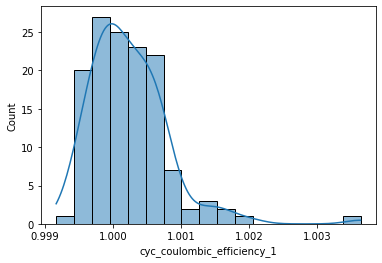

In [13]:
_ = sns.histplot(data = features_df, x = 'cyc_coulombic_efficiency_1', kde=True)

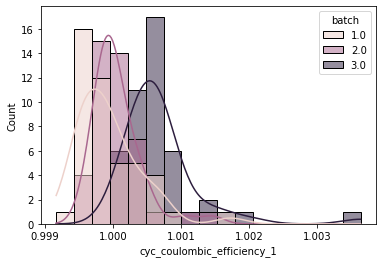

In [14]:
# we can group by the batch number as well:
_ = sns.histplot(data = features_df, x = 'cyc_coulombic_efficiency_1', hue='batch', kde=True)

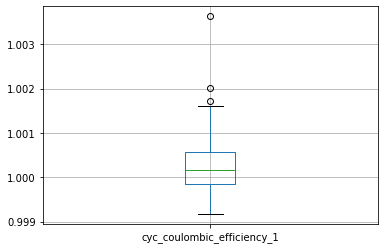

In [15]:
# Let's also take a look at box plots:
_ = features_df.boxplot(column = 'cyc_coulombic_efficiency_1')

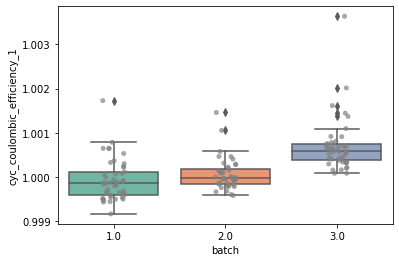

In [16]:
# Seaborn can provide a more nuanced analysis:
sns.boxplot(data = features_df,x = 'batch',y= 'cyc_coulombic_efficiency_1',saturation=0.75,palette="Set2")
_= sns.stripplot(data = features_df,x = 'batch',y= 'cyc_coulombic_efficiency_1', color='0.5',alpha=0.7)

Already from this initial visual analysis we might have identified a few outliers within our batch of cells. Let's now dig into the statistical and ML techniques for identifying outliers.

### Data Standardization and Scaling
For many of the techniques described below it is best for our feature dataset to be standardized and scaled. This ensures that if there are some features that are much larger in absolute terms than others, your models or analysis techniques will not over-emphasize or learn from that feature at the expense of others. Additionally many the statistical techniques assume nominally Gaussian-distributed data, which many of our features are not (see the long tail in coulombic efficiency, above). 

There are a number of scaling options implemented in Scikit-Learn's library which can be examined [here](https://scikit-learn.org/stable/modules/preprocessing.html).

In this tutorial we will be using the [StandardScaler method](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), which will roughly scale the data to have zero mean and unit variance.

In [105]:
from sklearn.preprocessing import StandardScaler

In [140]:
# scale all df inputs except for batch
scaler = StandardScaler()
scaler.fit(features_df.drop(columns='batch'))
scaled_df = (pd.DataFrame(StandardScaler().fit_transform(features_df.drop(columns='batch')), columns = features_df.columns.drop('batch'))
             .set_index(features_df.index)
            )
scaled_df['batch'] = features_df.batch
scaled_df

,cyc_coulombic_efficiency_1,cyc_coulombic_efficiency_10,cyc_coulombic_efficiency_100,cyc_discharge_capacity_1,cyc_discharge_capacity_10,cyc_discharge_capacity_100,cyc_charge_capacity_1,cyc_charge_capacity_10,cyc_charge_capacity_100,cyc_discharge_energy_1,...,cyc_max_potential_1,cyc_max_potential_10,cyc_max_potential_100,min_min_potential,mean_min_potential,max_max_potential,mean_max_potential,diff_dcap_10_100,diff_ccap_10_100,batch
2017-05-12_5_4C-70per_3C_CH17_VDF,-0.569175,0.219824,0.368330,-0.564424,-0.488328,-0.450903,-0.510753,-0.497804,-0.465459,-1.028807,...,0.793065,0.748974,0.729189,0.372794,0.833369,1.694142,0.337129,-0.194354,-0.202959,1.0
2017-05-12_5_4C-80per_5_4C_CH12_VDF,0.946223,1.408596,1.966167,1.303341,1.196149,0.376432,1.202945,1.126423,0.324098,1.473745,...,0.668599,0.729824,0.559608,0.346259,-0.218317,-0.841622,-0.034508,-0.600277,-0.628016,1.0
2017-05-12_5_4C-80per_5_4C_CH11_VDF,0.715000,1.057409,1.102574,0.180534,0.151522,-0.673276,0.126187,0.101047,-0.710559,0.187952,...,0.596456,0.756156,0.744907,0.349462,0.365075,-0.220223,0.028894,-1.141909,-1.159257,1.0
2017-05-12_4_8C-80per_4_8C_CH9_VDF,0.004428,-0.167376,0.403457,2.544086,2.417670,1.666990,2.476714,2.421179,1.671313,2.456240,...,0.551267,0.277392,0.326329,0.390603,0.804819,-0.431276,-0.086360,0.126353,0.103539,1.0
2017-05-12_4_8C-80per_4_8C_CH10_VDF,-0.616188,0.533933,0.716855,0.495916,0.708865,0.546859,0.525338,0.682037,0.531714,0.263768,...,0.483088,0.626889,0.800331,0.342613,0.532223,-0.854496,-0.065613,0.122934,0.119996,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-12_batch8_CH14_VDF,0.686301,0.004187,0.450011,0.355787,0.028683,0.181798,0.298749,0.028404,0.170863,0.714847,...,-1.641566,-1.290562,-1.692935,-0.895465,-0.902792,-0.872929,-1.073687,0.241030,0.226763,3.0
2018-04-12_batch8_CH13_VDF,0.940901,0.932572,1.240642,-0.721057,-0.949149,-0.514152,-0.766832,-0.991188,-0.553873,-0.066847,...,-1.173033,-1.221939,-1.677218,-0.661190,-1.051213,-0.876244,-1.075196,0.157799,0.151961,3.0
2018-04-12_batch8_CH12_VDF,1.164443,0.635633,0.778080,-0.979614,-1.189407,-0.716285,-1.033734,-1.216982,-0.744846,-0.074691,...,-1.573387,-1.549094,-1.487782,-0.197067,-1.471686,-0.870978,-1.064915,0.091318,0.089951,3.0
2018-04-12_batch8_CH11_VDF,0.740505,0.130031,0.655218,-0.499228,-0.621958,-0.318664,-0.537196,-0.626937,-0.340082,-0.218185,...,-1.357751,-1.157306,-1.081613,-0.003587,-0.448179,-0.854540,-1.063509,0.130382,0.111400,3.0


In [128]:
scaled_describe_df = scaled_df.describe()
scaled_describe_df

,cyc_coulombic_efficiency_1,cyc_coulombic_efficiency_10,cyc_coulombic_efficiency_100,cyc_discharge_capacity_1,cyc_discharge_capacity_10,cyc_discharge_capacity_100,cyc_charge_capacity_1,cyc_charge_capacity_10,cyc_charge_capacity_100,cyc_discharge_energy_1,...,cyc_max_potential_1,cyc_max_potential_10,cyc_max_potential_100,min_min_potential,mean_min_potential,max_max_potential,mean_max_potential,diff_dcap_10_100,diff_ccap_10_100,batch
count,1.340000e+02,1.340000e+02,1.340000e+02,1.340000e+02,1.340000e+02,1.340000e+02,1.340000e+02,1.340000e+02,1.340000e+02,1.340000e+02,...,1.340000e+02,1.340000e+02,1.340000e+02,1.340000e+02,1.340000e+02,1.340000e+02,1.340000e+02,1.340000e+02,1.340000e+02,134.000000
mean,3.140137e-13,1.052797e-12,-1.241003e-12,-1.631054e-14,-2.610101e-14,3.433613e-14,-2.304914e-14,8.218550e-15,2.999984e-14,2.237431e-14,...,-2.813883e-11,-2.205483e-11,4.496261e-12,-1.233548e-14,-3.658810e-12,-1.103761e-13,7.799926e-12,4.391181e-17,7.663853e-18,2.007463
std,1.003752e+00,1.003752e+00,1.003752e+00,1.003752e+00,1.003752e+00,1.003752e+00,1.003752e+00,1.003752e+00,1.003752e+00,1.003752e+00,...,1.003752e+00,1.003752e+00,1.003752e+00,1.003752e+00,1.003752e+00,1.003752e+00,1.003752e+00,1.003752e+00,1.003752e+00,0.827136
min,-1.830147e+00,-1.808636e+00,-7.003886e+00,-3.443542e+00,-2.654616e+00,-6.972959e+00,-3.321493e+00,-2.685533e+00,-6.926926e+00,-4.357519e+00,...,-1.838176e+00,-1.857099e+00,-1.807093e+00,-1.033130e+01,-9.536423e+00,-8.768405e-01,-1.091726e+00,-9.784425e+00,-9.806544e+00,1.000000
25%,-6.571407e-01,-3.657965e-01,-2.640486e-01,-5.009341e-01,-5.216943e-01,-3.196399e-01,-4.672470e-01,-5.084754e-01,-3.426646e-01,-4.715977e-01,...,-1.178384e+00,-1.153515e+00,-1.161441e+00,1.508075e-02,-2.411838e-01,-8.544313e-01,-9.431768e-01,1.143687e-01,9.128579e-02,1.000000
50%,-1.387993e-01,-1.569148e-01,2.388687e-02,4.175895e-02,2.793668e-02,1.605069e-01,2.329452e-02,1.470293e-02,1.733582e-01,5.788784e-02,...,5.512671e-01,5.566707e-01,4.094657e-01,2.712495e-01,1.953603e-01,-1.693954e-01,-2.087624e-02,2.048227e-01,1.991324e-01,2.000000
75%,5.633307e-01,2.179080e-01,4.029134e-01,6.524009e-01,7.350272e-01,6.078210e-01,6.796763e-01,7.439002e-01,6.074523e-01,6.823391e-01,...,8.013896e-01,7.721146e-01,8.067420e-01,3.446893e-01,4.735288e-01,6.053062e-01,5.186723e-01,3.135761e-01,3.136608e-01,3.000000
max,5.830122e+00,9.279476e+00,1.966167e+00,2.632782e+00,2.474907e+00,1.666990e+00,2.607423e+00,2.476282e+00,1.671313e+00,2.609911e+00,...,1.299653e+00,1.396104e+00,1.501821e+00,4.021300e-01,1.448295e+00,3.750405e+00,5.342902e+00,5.687441e-01,7.592199e-01,3.000000


##### Choose whether you'd like to use the scaled dataframe

In [129]:
use_scaled = True
if use_scaled:
    input_df_stats = scaled_df
    stats_describe_df = scaled_describe_df
else:
    input_df_stats = features_df
    stats_describe_df = describe_df

We will also create a two-feature dataframe for use in the next two sections; in this case we are focusing on the features coulombic efficiency and discharge energy

In [161]:
two_feature_df = input_df_stats[['cyc_coulombic_efficiency_1','cyc_discharge_energy_100']]

## Statistical approaches
Anomaly detection has historically been performed using probability and statistical analysis. In this section we will cover three basic statistical approaches for anomaly detection.
1. [Z-scores (and Robust/Modified Z-scores)](#Z-scores-and-Robust-Z-scores)
1. [Inter-Quartile Range](#Inter-Quartile-Range-(IQR)) (related to the box plots we created above!)
1. [Mahalanobis Distances](#Mahalanobis-Distances)

For any anomaly detection model chosen, we must understand the assumptions underpinning the model

### Z-scores and Robust Z-scores
The **Z-score** is a calculation of how many standard deviations a value is away from the mean. The formula is as follows:
$$z=\frac{x_{i}-\bar x}{\sigma}$$
where $\bar x$ is the mean and $\sigma$ is the standard deviation.

Note that the Z-score works best with a **symmetric, normal distribution**, since the mean and standard deviation are well defined. However, the mean and standard deviation are highly sensitive to outliers. Thus, it is often better to use the **Robust, or Modified, Z-score** which uses the median rather than the mean. The median of a distribution is less affected by outliers compared with the mean and can therefore be a more robust metric for distance measurements.
$$z_{R,i} = \frac{x_{i}-median(x)}{k*MAD(x)}$$
Here, $MAD(x)$ is the Median Absolute Deviation
$$MAD(x) = median(|x_{i}-median(x)|)$$
$k$ is an adjustment factor that depends on the distribution that you expect (normal distribution, etc.).

In Frequentist statistics, anything outside of three standard deviations is considered an outlier.

These are calculated on a single feature or axis, and would need to be explored for all of the features we have created above. For the sake of this tutorial we will focus on a single feature - the **first-cycle coulombic efficiency**, which we also analyzed visually above.

Further references:
- https://en.wikipedia.org/wiki/Standard_score
- https://en.wikipedia.org/wiki/Median_absolute_deviation

In [130]:
# recall that we've saved the statistics of each feature in our describe_df DataFrame, above. Let's take a look at the first cycle CE column:
display(stats_describe_df.cyc_coulombic_efficiency_1)

count    1.340000e+02
mean     3.140137e-13
std      1.003752e+00
min     -1.830147e+00
25%     -6.571407e-01
50%     -1.387993e-01
75%      5.633307e-01
max      5.830122e+00
Name: cyc_coulombic_efficiency_1, dtype: float64

In [131]:
# calculate mean, standard deviation
first_cyc_ce_mean = stats_describe_df.cyc_coulombic_efficiency_1['mean']
first_cyc_ce_std = stats_describe_df.cyc_coulombic_efficiency_1['std']
first_cyc_ce_median = stats_describe_df.cyc_coulombic_efficiency_1['50%']
median_absolute_deviation = np.median([abs(x - first_cyc_ce_median) for x in input_df_stats.cyc_coulombic_efficiency_1])

In [132]:
# next, we need to calculate the z-score and robust z-score for each sample
k = 1.4826 # assuming a normal distribution (note, you can tell that's not quite right based on our visualizations, above!!)
z_score = [(x - first_cyc_ce_mean)/first_cyc_ce_std for x in input_df_stats.cyc_coulombic_efficiency_1]
robust_z_score = [(x - first_cyc_ce_median)/(k*median_absolute_deviation) for x in input_df_stats.cyc_coulombic_efficiency_1]
z_score_df = pd.DataFrame({'batch':input_df_stats.batch,'z_score':z_score,'robust_z_score':robust_z_score})
z_score_df.head()

,batch,z_score,robust_z_score
2017-05-12_5_4C-70per_3C_CH17_VDF,1.0,-0.567047,-0.509150
2017-05-12_5_4C-80per_5_4C_CH12_VDF,1.0,0.942685,1.283621
2017-05-12_5_4C-80per_5_4C_CH11_VDF,1.0,0.712328,1.010077
2017-05-12_4_8C-80per_4_8C_CH9_VDF,1.0,0.004412,0.169444
2017-05-12_4_8C-80per_4_8C_CH10_VDF,1.0,-0.613885,-0.564769


Let's take a look at the z-score and robust z-scores visually, and identify whether there are any outliers:

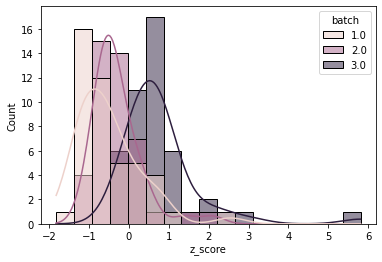

In [133]:
_ = sns.histplot(data = z_score_df, x = 'z_score', hue='batch', kde=True)

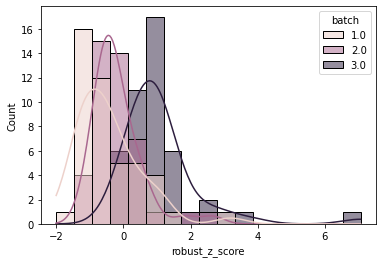

In [134]:
_ = sns.histplot(data = z_score_df, x = 'robust_z_score', hue='batch', kde=True)

As an important note, I'm visualizing the tests in batches above, but the z-scores were calculated on the entire sample

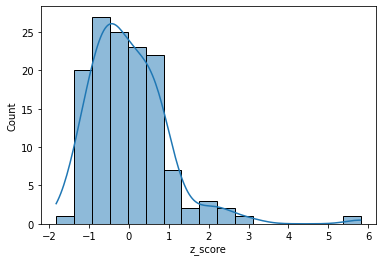

In [135]:
_ = sns.histplot(data = z_score_df, x = 'z_score', kde=True)

For z-scores, the outlier cut-off is generally taken to be >=3. For Robust z-scores this number can change, especially if the incorrect distribution were chosen. Let's assume a cut-off of three for this tutorial, and show which tests fall outside this cutoff.

In [136]:
outliers_z_score = z_score_df[abs(z_score_df.z_score) >= 3]
outliers_robust_z_score = z_score_df[abs(z_score_df.robust_z_score) >= 3]
print('Z-score outliers:')
display(outliers_z_score)
print('Robust Z-score outliers:')
display(outliers_robust_z_score)

Z-score outliers:


,batch,z_score,robust_z_score
2018-04-12_batch8_CH46_VDF,3.0,5.808327,7.061457
2018-04-12_batch8_CH1_VDF,3.0,3.041253,3.775622


Robust Z-score outliers:


,batch,z_score,robust_z_score
2017-05-12_5_4C-40per_3_6C_CH20_VDF,1.0,2.550617,3.193003
2018-04-12_batch8_CH46_VDF,3.0,5.808327,7.061457
2018-04-12_batch8_CH1_VDF,3.0,3.041253,3.775622


### Inter-Quartile Range (IQR)
The inter-quartile range (IQR) is another metric used for calculating outliers. The IQR defines the middle 50% of your data, between the 25th and 75th percentiles. To calculate 'outliers' within your data, a typical metric is to identify data that is further than [1.5$x$IQR](https://towardsdatascience.com/why-1-5-in-iqr-method-of-outlier-detection-5d07fdc82097) above the 75th percentile or below the 25th percentile. This is part of the visualization that comes with boxplots. The IQR technique works best with symmetric distributions, as otherwise many 'outliers' are likely to be detected.

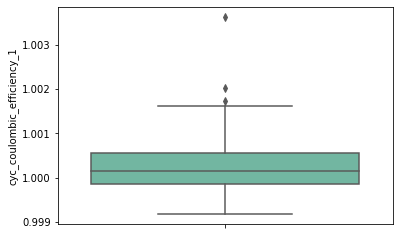

In [141]:
_=sns.boxplot(data = features_df,y= 'cyc_coulombic_efficiency_1',saturation=0.75,palette="Set2")

In [142]:
iqr = describe_df.cyc_coulombic_efficiency_1['75%'] - describe_df.cyc_coulombic_efficiency_1['25%']
top_outlier_cutoff = describe_df.cyc_coulombic_efficiency_1['75%'] + 1.5*iqr
bottom_outlier_cutoff = describe_df.cyc_coulombic_efficiency_1['25%'] - 1.5*iqr
iqr_outliers = features_df.cyc_coulombic_efficiency_1[(features_df.cyc_coulombic_efficiency_1 > top_outlier_cutoff)|(features_df.cyc_coulombic_efficiency_1 < bottom_outlier_cutoff)]
display(iqr_outliers)

2017-05-12_5_4C-40per_3_6C_CH20_VDF    1.001729
2018-04-12_batch8_CH46_VDF             1.003635
2018-04-12_batch8_CH1_VDF              1.002016
Name: cyc_coulombic_efficiency_1, dtype: float64

Note that we get the same three outlier cells as we saw for the robust z-score.

### Mahalanobis Distances
The previous two techniques are useful for working with a single feature or dimension of your data at a time. However, sometimes we might have outliers that are present based on the combination of multiple features. [Mahalanobis distances](https://en.wikipedia.org/wiki/Mahalanobis_distance) are a useful statistical technique for calculating outliers in this case. The Mahalanobis distance is calculated as a score of each point's distance away from the center of the distribution. Outliers are then identified based on a user-defined threshold. You can read more about this [here](https://www.machinelearningplus.com/statistics/mahalanobis-distance/). Mahalanobis distances are easiest to visualize in 2D, but can be calculated for any dimensional space.

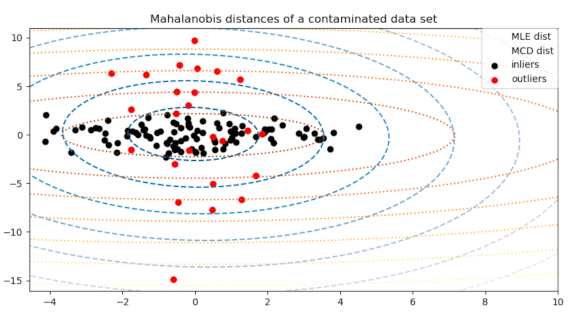

The Mahalanobis distance calculation can also be updated to be more robust by using the Minimum Covariance Determinant. Note that this only theoretically applies to **Gaussian-distributed data** and **will not apply for multi-modal data**.

We will be using the [Scikit-Learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope) to analyze outliers within our dataset. This implementation requires users to enter an expected 'contamination factor', or proportion of outliers in the data. The default is set to 0.1 (10%).

Here is [additional documentation](https://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_distances.html#sphx-glr-auto-examples-covariance-plot-mahalanobis-distances-py) on using this statistical technique as discussed in the sklearn package.

In [22]:
from sklearn.covariance import EllipticEnvelope

Let's take a look at two variables, the first cycle discharge energy versus the 10th cycle maximum potential:

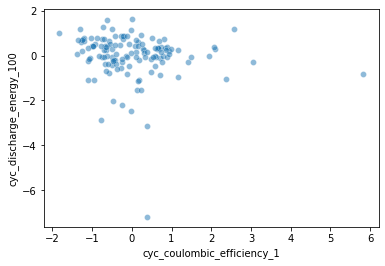

In [143]:
_ = sns.scatterplot(x = input_df_stats.cyc_coulombic_efficiency_1, y = input_df_stats.cyc_discharge_energy_100, alpha=0.5)

We can clearly see a few outliers at the edges, but are there more?

In [145]:
mahalanobis_2 = EllipticEnvelope(random_state=0).fit(two_feature_df)
mahalanobis_2_outlier_predict = mahalanobis_2.predict(two_feature_df)

In [146]:
mahalanobis_2_outlier = two_feature_df[mahalanobis_2_outlier_predict == -1]

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but EllipticEnvelope was fitted with feature names
  warnings.warn(


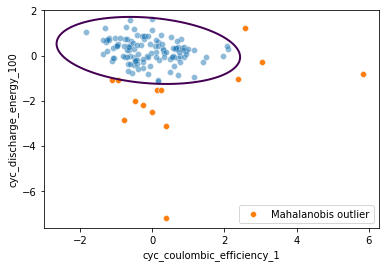

In [160]:
## Calculations for the decision boundary
xx1, yy1 = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-2,2, 500))
Z1 = mahalanobis_2.decision_function(np.c_[xx1.ravel(), yy1.ravel()])
Z1 = Z1.reshape(xx1.shape)
# create the plot
sns.scatterplot(x = input_df_stats.cyc_coulombic_efficiency_1, y = input_df_stats.cyc_discharge_energy_100, alpha=0.5)
# plot the decision boundary
plt.contour(xx1, yy1, Z1, levels=[0], linewidths=2)
_=sns.scatterplot(x = mahalanobis_2_outlier.cyc_coulombic_efficiency_1, y = mahalanobis_2_outlier.cyc_discharge_energy_100, alpha=1,label="Mahalanobis outlier")

We can also run the Mahalanobis calculation on all features; so the full multi-dimensional space

In [154]:
mahalanobis = EllipticEnvelope(random_state=0).fit(input_df_stats)
mahalanobis_outlier_predict = mahalanobis.predict(input_df_stats)

/opt/conda/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/covariance/_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-201.819212010837049 > -202.851328891292383). You may want to try with a higher value of support_fraction (current value: 0.612).
  warnings.warn(


In [157]:
mahalanobis_outlier = input_df_stats[mahalanobis_outlier_predict == -1]

The visualization is not as clean now, because the mahalanobis distance was calculated over the multi-dimensional feature space.

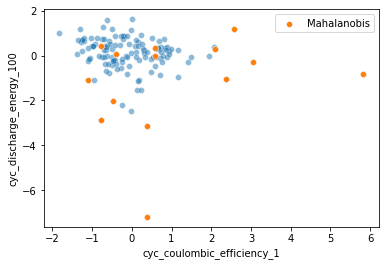

In [159]:
sns.scatterplot(x = input_df_stats.cyc_coulombic_efficiency_1, y = input_df_stats.cyc_discharge_energy_100, alpha=0.5)
_=sns.scatterplot(x = mahalanobis_outlier.cyc_coulombic_efficiency_1, y = mahalanobis_outlier.cyc_discharge_energy_100, alpha=1,label="Mahalanobis")

Recall that if we are using scaled values, the plots generated above will be centered around zero and will not have the original units; we can use the inverse_transform method of the scaler to get back to the original dataframe

## Machine learning (ML) approaches
The statistical outlier detection methods we discussed above are most useful when you are trying to identify outliers in single variables, or when you understand aspects of the distribtuion of your data. Additionally, they work better for global outlier detection, but not so well for local outlier detection.

ML approaches to outlier detection provide additional flexibility and relatively straightforward implementation using python packages such as Scikit-Learn and PyOD. This makes it easy to compare and contrast different methods and determine which one might work best for your usecase.

In this section of the tutorial, we will continue to focus on unsupervised anomaly detection - that is, we do not have labels that are associated with anomalous data. This means that ultimately we will need to explore the flagged anomalies directly, determine whether these anomalies are actually anomalies, and rank the different algorithms based on their performance for the task at hand. This [PyOD documentation](https://pyod.readthedocs.io/en/latest/relevant_knowledge.html) provides a good overview of unsupervised, semi-supervised versus supervised methods.

ML algorithms we will demonstrate here:
1. [k-Nearest Neighbors (KNN)](#k-Nearest-Neighbors): Global outliers
1. [Local Outlier Factor (LOF)](#Local-Outlier-Factor): Local outliers
1. [Isolation Forest (IF)](#Isolation-Forest): *can* provide feature importance
1. [Support Vector Machine (OCSVM)](#One-Class-Support-Vector-Machine): often semi-supervised

There are MANY options for anomaly detection using ML that we do not discuss in this tutorial. We focus specifically on unsupervised approaches, and on shallow-ML because we are working with a relatively small example dataset. Deep learning approaches, as well as supervised/semi-supervised approaches have also been explored and work well in a variety of cases. Additional information about various ML approaches to outlier detection as well as their general performance on tabular data can be found here: https://www.andrew.cmu.edu/user/yuezhao2/papers/22-preprint-adbench.pdf. Scikit-Learn also has a section on outlier detection: https://scikit-learn.org/stable/modules/outlier_detection.html

Lastly, we will not discuss anomaly detection as it relates to time-series data. This is a rich topic space that could be the focus of a future tutorial.

For visualization purposes we will be working with our two-feature dataframe(`two_feature_df`) for most of this tutorial. In all cases, the code can be swapped out to use the full feature dataframe (scaled or not scaled depending on our choice in section 1) in this next line:

##### Chose whether to look at two features or all features:

In [162]:
input_df = two_feature_df # can swap this to input_df_stats as desired
input_df.head()

,cyc_coulombic_efficiency_1,cyc_discharge_energy_100
2017-05-12_5_4C-70per_3C_CH17_VDF,-0.569175,-0.781104
2017-05-12_5_4C-80per_5_4C_CH12_VDF,0.946223,0.215984
2017-05-12_5_4C-80per_5_4C_CH11_VDF,0.715000,-0.843237
2017-05-12_4_8C-80per_4_8C_CH9_VDF,0.004428,1.612607
2017-05-12_4_8C-80per_4_8C_CH10_VDF,-0.616188,0.441311


### k-Nearest Neighbors
k-Nearest Neighbors (KNN) uses proximity calculations between a data point and its *k* nearest neighboring points to determine whether a point is an outlier. This method works best for global outlier detection, since the outlier must on average be farther away from its surrounding *k* points to be detected as an outlier. Additional information can be found here and [here](https://towardsdatascience.com/k-nearest-neighbors-knn-for-anomaly-detection-fdf8ee160d13).

The number of nearest neighbors to take into account is this model's adjustable parameter, and is given by *k*. In this tutorial we will set this to 10, but this should be adjusted based on the use case and sensitivity you'd like to achieve in your outlier detection.

Additionally, we need to select the cutoff threshold for what determines an outlier. We can do this in a few ways:
1. [Visualize the nearest-neighbor calculations for our dataset and determine a relevant threshold](#Visualize-kNN-calculation-to-determine-threshold) ([Reference](https://towardsdatascience.com/k-nearest-neighbors-knn-for-anomaly-detection-fdf8ee160d13))
1. Select a threshold based on some statistical calculation - such as an expected amount of 'contamination' or outliers within the data (see the option below)
1. [Use a python library to do the thinking for us](#PyOD-library-kNN-implementation) - in this example we will explore [PyOD](https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod.models.knn.KNN)

In [163]:
from sklearn.neighbors import NearestNeighbors

#### Visualize kNN calculation to determine threshold

In [164]:
# instantiate the model
knn = NearestNeighbors(n_neighbors = 10)

# fit model
knn.fit(input_df)

NearestNeighbors(n_neighbors=10)

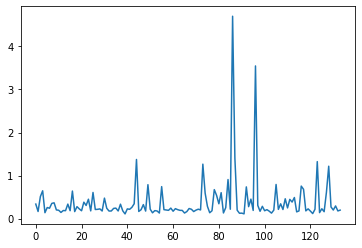

In [165]:
# distances and indexes of k-neaighbors from model outputs
distances, indexes = knn.kneighbors(input_df)
# plot mean of k-distances of each observation
_=plt.plot(distances.mean(axis =1))

Based on this visualization we might choose a threshold of 1, arbitrarily...

In [167]:
threshold = 1

# visually determine cutoff values > threshold
outlier_index = np.where(distances.mean(axis = 1) > threshold)
outlier_index

(array([ 44,  73,  86,  87,  96, 123, 128]),)

In [177]:
# now we can pull those indices from our feature dataframe
knn_outliers_visual_sklearn = input_df.iloc[outlier_index]
knn_outliers_visual_sklearn

,cyc_coulombic_efficiency_1,cyc_discharge_energy_100
2017-05-12_5_4C-40per_3_6C_CH20_VDF,2.560188,1.203884
2017-06-30_4_4C-55per_6C_CH19_VDF,-0.770210,-2.863687
2017-06-30_2C-10per_6C_CH10_VDF,0.393827,-7.186883
2017-06-30_1C-4per_6C_CH9_VDF,0.392256,-3.119645
2018-04-12_batch8_CH46_VDF,5.830122,-0.813324
2018-04-12_batch8_CH1_VDF,3.052665,-0.278356
2018-04-12_batch8_CH15_VDF,2.366686,-1.047391


Let's visualize these tests based on two axes of data:

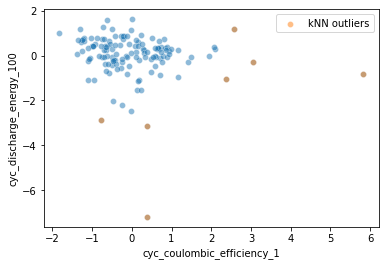

In [178]:
sns.scatterplot(x = input_df.cyc_coulombic_efficiency_1, y = input_df.cyc_discharge_energy_100, alpha=0.5)
_=sns.scatterplot(x = knn_outliers_visual_sklearn.cyc_coulombic_efficiency_1, y = knn_outliers_visual_sklearn.cyc_discharge_energy_100, alpha=0.5,label="kNN outliers")

## Exercise:
If you chose to use the scaled dataframe, redo the analysis with the unscaled dataframe ([make the change here](#Choose-whether-you'd-like-to-use-the-scaled-dataframe)). How do the results change? 

(Hint: you should see that scaling the dataframe ensures that we detect outliers in both dimensions, while the unscaled dataframe prioritizes outliers in the discharge energy dimension because the values are larger)

#### PyOD library kNN implementation
This library calculates outliers based on an expected 'contamination' factor input, which is the fraction of data that are suspected to be outliers

In [170]:
from pyod.models.knn import KNN as py_KNN

In [171]:
set_contamination = 0.05 #make an assumption on the fraction of outliers
pyod_knn = py_KNN(contamination = set_contamination,n_neighbors=10) # default nearest neighbors (n_neighbors=5)
pyod_knn.fit(input_df)

KNN(algorithm='auto', contamination=0.05, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=10, p=2,
  radius=1.0)

In [172]:
# get the prediction labels and outlier scores of the training data
pyod_knn_outlier_pred = pyod_knn.labels_  # binary labels (0: inliers, 1: outliers)
pyod_knn_outlier_scores = pyod_knn.decision_scores_  # raw outlier scores

In [173]:
pyod_knn_outliers = input_df[pyod_knn_outlier_pred == 1]
pyod_knn_outliers

,cyc_coulombic_efficiency_1,cyc_discharge_energy_100
2017-05-12_5_4C-40per_3_6C_CH20_VDF,2.560188,1.203884
2017-06-30_4_4C-55per_6C_CH19_VDF,-0.770210,-2.863687
2017-06-30_2C-10per_6C_CH10_VDF,0.393827,-7.186883
2017-06-30_1C-4per_6C_CH9_VDF,0.392256,-3.119645
2018-04-12_batch8_CH46_VDF,5.830122,-0.813324
2018-04-12_batch8_CH1_VDF,3.052665,-0.278356
2018-04-12_batch8_CH15_VDF,2.366686,-1.047391


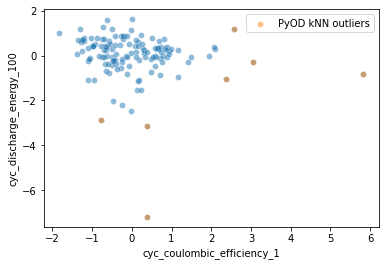

In [174]:
sns.scatterplot(x = input_df.cyc_coulombic_efficiency_1, y = input_df.cyc_discharge_energy_100, alpha=0.5)
_=sns.scatterplot(x = pyod_knn_outliers.cyc_coulombic_efficiency_1, y = pyod_knn_outliers.cyc_discharge_energy_100, alpha=0.5,label="PyOD kNN outliers")

Unsurprisingly, this gives very similar results to the method above. Depending on the visual threshold we set, we might see a small difference in the number of detected outliers:

In [179]:
print("Num PyOD KNN outliers:",len(pyod_knn_outliers))
print("Num sklearn KNN outliers:",len(knn_outliers_visual_sklearn))

Num PyOD KNN outliers: 7
Num sklearn KNN outliers: 7


### Local Outlier Factor
As its name implies, Local Outlier Factor (LOF) works well for identifying local outliers, rather than global outliers. LOF uses a distance-based metric focusing on the local density of each point with respect to the density of its *k* nearest neighbors. You can read more about the algorithm [here](https://en.wikipedia.org/wiki/Local_outlier_factor), as well as its [scikit-learn implementation](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html#:~:text=The%20Local%20Outlier%20Factor%20(LOF,lower%20density%20than%20their%20neighbors.).

Similar to kNN, a user must select the *k* nearest neighbors to consider.

The example below uses the LOF implementation from sklearn; [pyOD](https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod.models.lof.LOF) likewise has a LOF implementation (note there are a few nuanced differences between the two, including what the definition of an outlier output is (-1 for sklearn, 1 for pyod)).

In [180]:
from sklearn.neighbors import LocalOutlierFactor

In [181]:
lof = LocalOutlierFactor() # the default number of neighbors is 20
lof_predict = lof.fit_predict(input_df)
lof_scores = lof.negative_outlier_factor_

Let's take a look at the list of tests that were determined to be outliers. Outliers have a prediction output of -1, while inliers are set to 1

In [182]:
lof_outliers = input_df[lof_predict == -1]
lof_outliers

,cyc_coulombic_efficiency_1,cyc_discharge_energy_100
2017-05-12_4_8C-80per_4_8C_CH9_VDF,0.004428,1.612607
2017-05-12_8C-15per_3_6C_CH43_VDF,-1.830147,1.023046
2017-05-12_6C-50per_3_6C_CH36_VDF,-0.624657,1.581125
2017-05-12_5_4C-40per_3_6C_CH20_VDF,2.560188,1.203884
2017-06-30_6C-60per_3C_CH48_VDF,-0.475038,-2.005746
2017-06-30_5_6C-5per_4_75C_CH41_VDF,2.101383,0.291757
2017-06-30_4_4C-55per_6C_CH19_VDF,-0.770210,-2.863687
2017-06-30_4_4C-47per_5_5C_CH18_VDF,-0.949569,-1.075133
2017-06-30_4C-31per_5_5C_CH28_VDF,-1.113846,-1.089904
2017-06-30_4C-13per_5C_CH27_VDF,1.405780,-0.303827


21 tests were determined to be outliers in this dataset. We can visualize them on the same axes as we did for kNN:

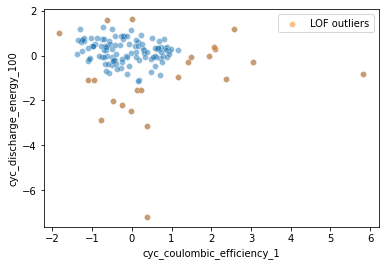

In [183]:
sns.scatterplot(x = input_df.cyc_coulombic_efficiency_1, y = input_df.cyc_discharge_energy_100, alpha=0.5)
_=sns.scatterplot(x = lof_outliers.cyc_coulombic_efficiency_1, y = lof_outliers.cyc_discharge_energy_100, alpha=0.5,label="LOF outliers")

## Exercise
Recall that in this tutorial as it's written we've chosen to work only with two features, rather than with all features. If you go back and [change this](#Chose-whether-to-look-at-two-features-or-all-features:) to look at all features, but then create the same visualizations based only on these two features, the decision boundaries will be much less straightforward.

Unfortunately, visualizing which features/dimensions were most important for determining outliers is not possible/straightforward. One method is to try to visualize 2 or 3 features (aka dimensions) at a time and visually try to determine the most important features. Alternatively, one could perform LOF analysis on one or two dimensions at a time which would provide easier visualization of the outliers; however this approach takes us back towards the same downsides as the statistical measures since we are no longer examining the datapoints in the full-dimensional space.

### Isolation Forest
Isolation Forest is an ML algorithm that creates randomly-split decision trees to isolate each data point. If a data point can be isolated in fewer splits/decisions, then it is much more likely to be an outlier. 
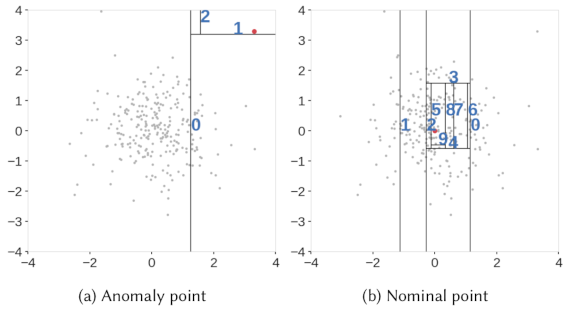

Additional details on concepts surrounding IF can be found [here](https://www.analyticsvidhya.com/blog/2021/07/anomaly-detection-using-isolation-forest-a-complete-guide/), and here are the [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html) and [PyOD](https://pyod.readthedocs.io/en/latest/pyod.models.html#pyod.models.iforest.IForest) implementations.

Isolation Forest suffers from artifacts that arise based on splitting points directly along single dimensions within your feature space. An updated algorithm called the [Extended Isolation Forest](https://arxiv.org/abs/1811.02141) was develope to cope with this but requires an additional package installation (see the [GitHub repo](https://github.com/sahandha/eif#The-Code)).

In [184]:
from sklearn.ensemble import IsolationForest

In [185]:
if_clf = IsolationForest()
if_predict = if_clf.fit_predict(input_df) # returns -1 for outliers

In [186]:
if_outliers = input_df[if_predict == -1]
if_outliers

,cyc_coulombic_efficiency_1,cyc_discharge_energy_100
2017-05-12_4_8C-80per_4_8C_CH9_VDF,0.004428,1.612607
2017-05-12_8C-15per_3_6C_CH43_VDF,-1.830147,1.023046
2017-05-12_6C-50per_3_6C_CH36_VDF,-0.624657,1.581125
2017-05-12_6C-40per_3_6C_CH33_VDF,-1.300762,1.203781
2017-05-12_5_4C-40per_3_6C_CH20_VDF,2.560188,1.203884
2017-06-30_6C-60per_3C_CH48_VDF,-0.475038,-2.005746
2017-06-30_5_6C-5per_4_75C_CH41_VDF,2.101383,0.291757
2017-06-30_4_4C-55per_6C_CH19_VDF,-0.770210,-2.863687
2017-06-30_4C-31per_5_5C_CH28_VDF,-1.113846,-1.089904
2017-06-30_2C-7per_5_5C_CH12_VDF,-0.012065,-2.486572


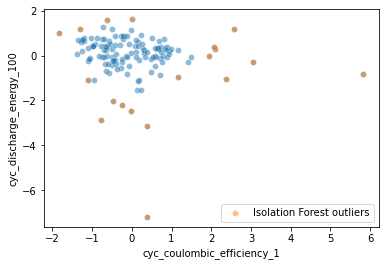

In [187]:
sns.scatterplot(x = input_df.cyc_coulombic_efficiency_1, y = input_df.cyc_discharge_energy_100, alpha=0.5)
_=sns.scatterplot(x = if_outliers.cyc_coulombic_efficiency_1, y = if_outliers.cyc_discharge_energy_100, alpha=0.5,label="Isolation Forest outliers")

For the IF algorithm we can begin to examine feature importances, at least using the PyOD implementation:

In [188]:
from pyod.models.iforest import IForest
pyod_if = IForest()
pyod_if.fit(input_df)

IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [189]:
# confirm that the pyod results are roughly the same:
pyod_if_outliers = input_df[pyod_if.labels_ == 1]
print("PyOD IF number of outliers: ", len(pyod_if_outliers))
print("sklearn IF number of outliers: ", len(if_outliers))

PyOD IF number of outliers:  14
sklearn IF number of outliers:  19


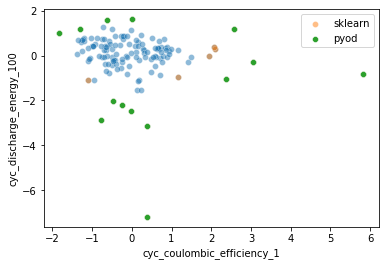

In [191]:
sns.scatterplot(x = input_df.cyc_coulombic_efficiency_1, y = input_df.cyc_discharge_energy_100, alpha=0.5)
sns.scatterplot(x = if_outliers.cyc_coulombic_efficiency_1, y = if_outliers.cyc_discharge_energy_100, alpha=0.5,label='sklearn')
_=sns.scatterplot(x = pyod_if_outliers.cyc_coulombic_efficiency_1, y = pyod_if_outliers.cyc_discharge_energy_100, alpha=1,label = 'pyod')

In [193]:
# example of the feature importance; this is more useful important when looking at more than two features
feature_importance = pyod_if.feature_importances_
features = list(input_df.columns)
feature_importance_df = pd.DataFrame({"Feature":features,"Importance":feature_importance})
feature_importance_df_sort = feature_importance_df.sort_values(by="Importance",ascending=False)
display(feature_importance_df_sort)

,Feature,Importance
1,cyc_discharge_energy_100,0.512976
0,cyc_coulombic_efficiency_1,0.487024


### One Class Support Vector Machine
Support Vector Machines (SVMs) can also be used for anomaly detection [(ref)](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-99-87.pdf). Most commonly, they are used for novelty detection, which means that they are trained on 'normal' data and can then identify anomalous data (this is a semi-supervised approach). We will use this as a completely unsupervised method in this tutorial. Here is the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM).

In [194]:
from sklearn.svm import OneClassSVM

In [195]:
ocsvm = OneClassSVM()
ocsvm.fit(input_df)
ocsvm_predict = ocsvm.predict(input_df)

In [196]:
ocsvm_outliers = input_df[ocsvm_predict == -1]
ocsvm_outliers

,cyc_coulombic_efficiency_1,cyc_discharge_energy_100
2017-05-12_5_4C-70per_3C_CH17_VDF,-0.569175,-0.781104
2017-05-12_5_4C-80per_5_4C_CH12_VDF,0.946223,0.215984
2017-05-12_5_4C-80per_5_4C_CH11_VDF,0.715000,-0.843237
2017-05-12_4_8C-80per_4_8C_CH9_VDF,0.004428,1.612607
2017-05-12_4C-80per_4C_CH6_VDF,-0.416316,0.892003
...,...,...
2018-04-12_batch8_CH16_VDF,0.242709,-1.517306
2018-04-12_batch8_CH15_VDF,2.366686,-1.047391
2018-04-12_batch8_CH14_VDF,0.686301,0.661120
2018-04-12_batch8_CH13_VDF,0.940901,0.066475


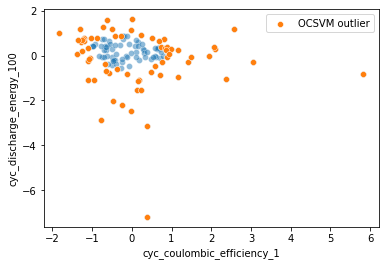

In [198]:
sns.scatterplot(x = input_df.cyc_coulombic_efficiency_1, y = input_df.cyc_discharge_energy_100, alpha=0.5)
_=sns.scatterplot(x = ocsvm_outliers.cyc_coulombic_efficiency_1, y = ocsvm_outliers.cyc_discharge_energy_100, alpha=1,label='OCSVM outlier')

This approach identifies a much large proportion of outliers. If you were testing this approach using the unscaled data you will notice that it misses a few important outliers as plotted along the two axes of first cycle CE and 100th cycle discharge energy.

## Summary
We've walked through a small number of statistical and machine learning approaches for anomaly detection, applied to a small dataset of fast-charging 18650 cells.

We began by performing feature engineering, and selected a small number of features to calculate based on our cycling data. Again **feature engineering is the most important step in anomaly detection**, because any algorithm can only detect anomalies based on the information provided to it. More thoughtful features, especially those that are directly relevant to battery safety or product performance, will result in more performant and simpler algorithms.

After exploring some anomaly detection algorithm, the last step would be to select an algorithm (or a set of algorithms) to deploy for anomaly detection in your use case. If you decide to use a single algorithm, be sure to explore the outputs for a variety of data sets, and determine whether the algorithm behaves as you would expect. Continuous monitoring is important! If you select a series of algorithms, a common approach would be to flag anomalies that were detected by multiple algorithms, by building a system of weighted average scores. These cells are more likely to be true anomalies if they were selected by multiple algorithms.

Lastly, as with all ML approaches, explainability is important. Flagging anomalies is the first step in the prevention of future issues, but will only get you so far. It is important to go back to those anomalous cells and identify exactly why that cell might be an anomaly. This requires additional exploratory data analysis, or alternatively performing anomaly detection on a smaller dimensional space such that key outlier 'features' can be identified (e.g. is the cell anomalous due to a single feature, or is it a combination of features?).

In [199]:
# first I will match the outlier convention between sklearn and pyod
pyod_knn_outlier_pred_update = np.array(pyod_knn_outlier_pred)
pyod_knn_outlier_pred_update[pyod_knn_outlier_pred_update == 1] = -1
pyod_knn_outlier_pred_update[pyod_knn_outlier_pred_update == 0] = 1
pyod_knn_outlier_pred_update

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1])

In [200]:
# sample code for providing a weighted score for each cell based on the anomaly detection method. 
anom_df = pd.DataFrame({"Name":input_df.index,"knn_pyod":pyod_knn_outlier_pred_update, "lof":lof_predict,"if":if_predict,"ocsvm":ocsvm_predict}).replace(to_replace = {1:0,-1:1}).set_index('Name')
anom_df.head()

,knn_pyod,lof,if,ocsvm
Name,,,,
2017-05-12_5_4C-70per_3C_CH17_VDF,0,0,0,1
2017-05-12_5_4C-80per_5_4C_CH12_VDF,0,0,0,1
2017-05-12_5_4C-80per_5_4C_CH11_VDF,0,0,0,1
2017-05-12_4_8C-80per_4_8C_CH9_VDF,0,1,1,1
2017-05-12_4_8C-80per_4_8C_CH10_VDF,0,0,0,0


In [201]:
anom_df['score'] = anom_df.sum(axis=1)
anom_df.head()

,knn_pyod,lof,if,ocsvm,score
Name,,,,,
2017-05-12_5_4C-70per_3C_CH17_VDF,0,0,0,1,1
2017-05-12_5_4C-80per_5_4C_CH12_VDF,0,0,0,1,1
2017-05-12_5_4C-80per_5_4C_CH11_VDF,0,0,0,1,1
2017-05-12_4_8C-80per_4_8C_CH9_VDF,0,1,1,1,3
2017-05-12_4_8C-80per_4_8C_CH10_VDF,0,0,0,0,0


In [202]:
# sort the dataframe to see the highest values
anom_df_sort = anom_df.sort_values('score', ascending=False)
anom_df_sort

,knn_pyod,lof,if,ocsvm,score
Name,,,,,
2017-05-12_5_4C-40per_3_6C_CH20_VDF,1,1,1,1,4
2018-04-12_batch8_CH15_VDF,1,1,1,1,4
2017-06-30_2C-10per_6C_CH10_VDF,1,1,1,1,4
2017-06-30_4_4C-55per_6C_CH19_VDF,1,1,1,1,4
2018-04-12_batch8_CH46_VDF,1,1,1,1,4
...,...,...,...,...,...
2017-06-30_5_6C-47per_4C_CH39_VDF,0,0,0,0,0
2017-06-30_5_6C-58per_3_5C_CH40_VDF,0,0,0,0,0
2017-06-30_5_6C-65per_3C_CH42_VDF,0,0,0,0,0


In [203]:
# let's see all the tests that were selected by at least three of the four algorithms:
outliers_3of4 = anom_df_sort[anom_df_sort.score >=3]
outliers_3of4

,knn_pyod,lof,if,ocsvm,score
Name,,,,,
2017-05-12_5_4C-40per_3_6C_CH20_VDF,1,1,1,1,4
2018-04-12_batch8_CH15_VDF,1,1,1,1,4
2017-06-30_2C-10per_6C_CH10_VDF,1,1,1,1,4
2017-06-30_4_4C-55per_6C_CH19_VDF,1,1,1,1,4
2018-04-12_batch8_CH46_VDF,1,1,1,1,4
2018-04-12_batch8_CH1_VDF,1,1,1,1,4
2017-06-30_1C-4per_6C_CH9_VDF,1,1,1,1,4
2017-05-12_6C-50per_3_6C_CH36_VDF,0,1,1,1,3
2017-05-12_8C-15per_3_6C_CH43_VDF,0,1,1,1,3


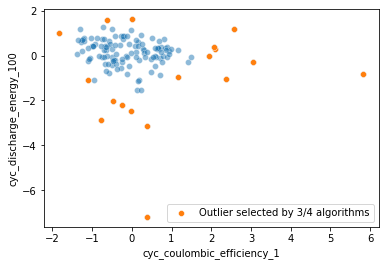

In [205]:
# for a final visualization:
sns.scatterplot(x = input_df.cyc_coulombic_efficiency_1, y = input_df.cyc_discharge_energy_100, alpha=0.5)
_=sns.scatterplot(x = input_df.loc[outliers_3of4.index].cyc_coulombic_efficiency_1, y = input_df.loc[outliers_3of4.index].cyc_discharge_energy_100, alpha=1,label='Outlier selected by 3/4 algorithms')